# Detection - **Post-processing**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import csv

import pandas as pd
from scipy.signal import medfilt
from scipy.signal import savgol_filter

Auxiliary data and functions

In [6]:
def plot_trajectory(df):
    plt.figure(figsize=(8,6))
    plt.plot(df['X'], -df['Y'], 'o-', label='Cleaned Trajectory')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cleaned Ball Trajectory')
    plt.legend()
    plt.show()

Clean the points before a certain frame and after another one

In [7]:
def clear_outside_frame_range(df, min_frame=50, max_frame=200):
    # Set 'X' and 'Y' to NaN for frames outside the specified range
    df.loc[(df['Frame'] < min_frame) | (df['Frame'] > max_frame), ['X', 'Y']] = np.nan
    return df

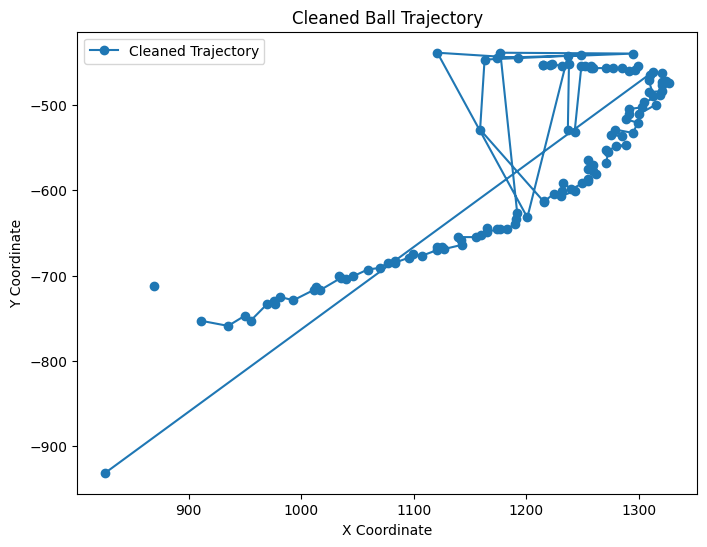

In [8]:
# Example usage
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / "Circle_positions_2.0.csv")
df = pd.read_csv(CSV_POSITIONS_FILE_PATH)

df = clear_outside_frame_range(df)

plot_trajectory(df)

Post-processing on the points removing the outliers

In [9]:
def remove_outliers(df, threshold=0.1):
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')

    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()
    distances = np.sqrt(dx**2 + dy**2)

    # Define outlier threshold
    median_dist = distances.median()
    std_dist = distances.std()
    outlier_threshold = median_dist + threshold * std_dist

    # Keep only points that are within the threshold
    df_cleaned = df[distances <= outlier_threshold].copy().reset_index(drop=True)

    # Convert coordinates to integers
    df_cleaned[['X', 'Y']] = df_cleaned[['X', 'Y']].round().astype(int)

    return df_cleaned

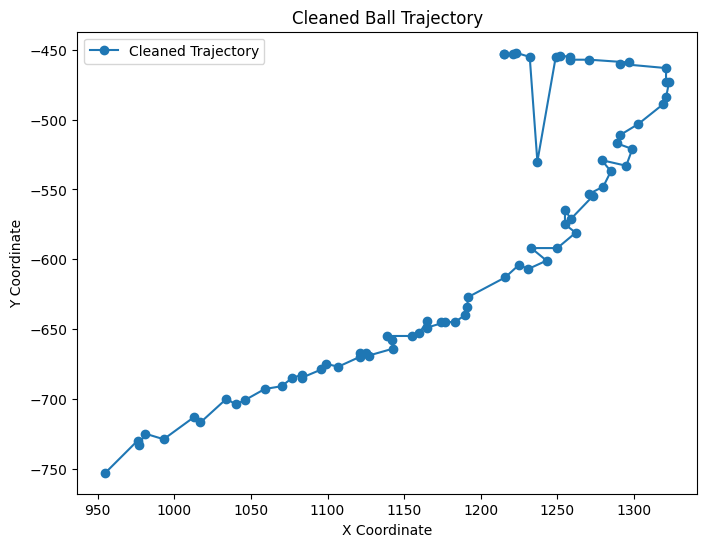

In [10]:
# Example usage
df_cleaned = remove_outliers(df)
plot_trajectory(df_cleaned)

In [11]:
def median_filter(df, kernel_size=5):
    """
    Smooths the X and Y coordinates using a median filter to reduce noise.
    """
    # Apply a median filter to smooth the coordinates (kernel size 5 by default)
    df['X'] = medfilt(df['X'], kernel_size=kernel_size)
    df['Y'] = medfilt(df['Y'], kernel_size=kernel_size)
    
    return df

In [12]:
def Savitzky_Golay_filter(df, window_length=25, polyorder=1):
    """
    Smooths the X and Y coordinates using Savitzky-Golay filter to reduce noise.
    """
    df['X'] = savgol_filter(df['X'], window_length=window_length, polyorder=polyorder)
    df['Y'] = savgol_filter(df['Y'], window_length=window_length, polyorder=polyorder)
    
    # Round the smoothed coordinates to integers
    df['X'] = df['X'].round().astype(int)
    df['Y'] = df['Y'].round().astype(int)
    
    return df

In [13]:
def interpolate_missing_coordinates(df, start_frame=50, end_frame=200):
    """
    Interpolate the missing coordinates between the frames from start_frame to end_frame.
    Ensures a smooth trajectory by interpolating both X and Y coordinates.
    """
    # Create a DataFrame with all frames from start_frame to end_frame
    all_frames = pd.DataFrame({'Frame': range(start_frame, end_frame + 1)})
    
    # Merge with the original dataframe
    df_full = pd.merge(all_frames, df, on='Frame', how='left')
    
    # Interpolate the missing 'X' and 'Y' coordinates (linear interpolation)
    df_full['X'] = df_full['X'].interpolate(method='linear')
    df_full['Y'] = df_full['Y'].interpolate(method='linear')

    # Fill any remaining NaN values using forward and backward filling
    df_full['X'] = df_full['X'].bfill().ffill()
    df_full['Y'] = df_full['Y'].bfill().ffill()
    
    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)
    
    return df_full

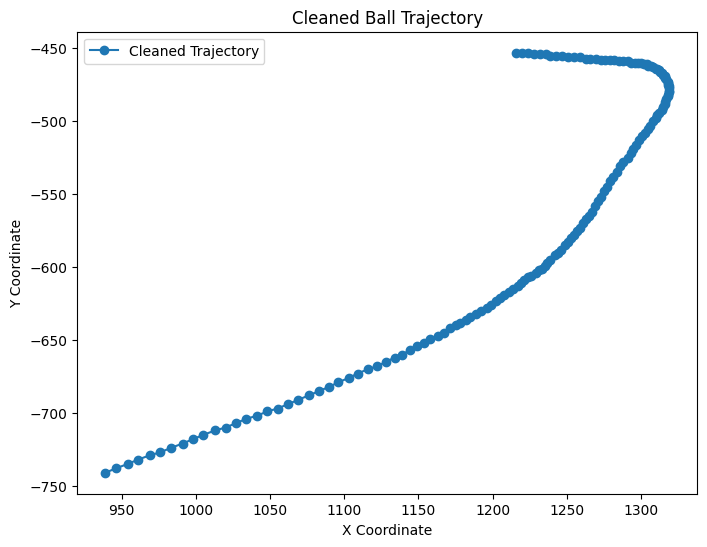

In [14]:
# Smooth the trajectory to reduce noise
df_smoothed = median_filter(df_cleaned)

# Interpolate missing coordinates
df_interpolated = interpolate_missing_coordinates(df_smoothed)

# Now you can plot the result
plot_trajectory(df_interpolated)

In [15]:
# Save cleaned data
OUTPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / "Circle_positions_2_clean.csv")
df_interpolated.to_csv(OUTPUT_CSV_PATH, index=False)

Here the things to do are:
- start and finish detection when the ball enters and exits the track (required track detection).
        How to know when the ball is arrived at the end?